In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 특정 GPU에 1GB 메모리만 할당하도록 제한
    try:
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        tf.config.experimental.set_virtual_device_configuration(
            gpus[1],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2024)])
    except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
        print(e)

In [2]:
import os
import os.path as pth
import json
import shutil
import pandas as pd
from tqdm import tqdm

data_base_path = pth.join('data', 'deepfake')
os.makedirs(data_base_path, exist_ok=True)
print(data_base_path)

data/deepfake


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import cv2

import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, GroupKFold, RepeatedStratifiedKFold
from sklearn.utils import shuffle

import numpy as np
import pandas as pd
import os
import os.path as pth
import shutil
import time
import random
from tqdm import tqdm

import numpy as np
from PIL import Image

from IPython.display import clear_output

from multiprocessing import Process, Queue
import datetime

In [4]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _floatarray_feature(array):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=array))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def _validate_text(text):
    """If text is not str or unicode, then try to convert it to str."""
    if isinstance(text, str):
        return text
    elif isinstance(text, 'unicode'):
        return text.encode('utf8', 'ignore')
    else:
        return str(text)


# def to_tfrecords(id_list, randmark_id_list, tfrecords_name):
#     print("Start converting")
#     options = tf.io.TFRecordOptions(compression_type = 'GZIP')
#     with tf.io.TFRecordWriter(path=pth.join(tfrecords_name+'.tfrecords'), options=options) as writer:
#         for id_, randmark_id in tqdm(zip(id_list, randmark_id_list), total=len(id_list), position=0, leave=True):
#             image_path = pth.join(train_data_path, id_+'.JPG')
#             _binary_image = tf.io.read_file(image_path)

#             string_set = tf.train.Example(features=tf.train.Features(feature={
#                 'image_raw': _bytes_feature(_binary_image),
#                 'randmark_id': _int64_feature(randmark_id),
#                 'id': _bytes_feature(id_.encode()),
#             }))

#             writer.write(string_set.SerializeToString())    

fake_label, real_label = 1, 0

fake_img_data_path = '/home/lab03/data/project_deepfake/train/fake'    # 현규
real_img_data_path = '/home/lab22/data/project_deepfake/train_new/real_samp_by_folder'    # 진녕
fake_img_list = os.listdir(fake_img_data_path)
real_img_list = os.listdir(real_img_data_path)

validation_rate = 0.2
fake_val_img_list = random.sample(fake_img_list, int(np.ceil(len(fake_img_list)*validation_rate)))
real_val_img_list = random.sample(real_img_list, int(np.ceil(len(real_img_list)*validation_rate)))

def to_tfrecords(fake_img_list, real_img_list, tfrecords_name):
    print("Start converting")
    options = tf.io.TFRecordOptions(compression_type = 'GZIP')
    with tf.io.TFRecordWriter(path=pth.join(tfrecords_name+'.tfrecords'), options=options) as writer:
        for fake in tqdm(fake_img_list, total=len(fake_img_list), position=0, leave=True):
            image_path = pth.join(fake_img_data_path, fake)
            _binary_image = tf.io.read_file(image_path)

            string_set = tf.train.Example(features=tf.train.Features(feature={
                'image_raw': _bytes_feature(_binary_image),
                '_label': _int64_feature(fake_label),
#                 'id': _bytes_feature(id_.encode()),
            }))

            writer.write(string_set.SerializeToString())
        for real in tqdm(real_img_list, total=len(real_img_list), position=0, leave=True):
            image_path = pth.join(real_img_data_path, real)
            _binary_image = tf.io.read_file(image_path)

            string_set = tf.train.Example(features=tf.train.Features(feature={
                'image_raw': _bytes_feature(_binary_image),
                '_label': _int64_feature(real_label),
#                 'id': _bytes_feature(id_.encode()),
            }))

            writer.write(string_set.SerializeToString())        

In [5]:
print(len(fake_img_list))
print(len(real_img_list))

171614
66674


In [6]:
# tfrecord 생성

to_tfrecords(fake_img_list, real_img_list, pth.join(data_base_path, 'all_train'))
to_tfrecords(fake_val_img_list, real_val_img_list, pth.join(data_base_path, 'all_val'))

  0%|          | 1/171614 [00:00<5:08:49,  9.26it/s]

Start converting


  0%|          | 53/34323 [00:00<01:06, 516.46it/s]

Start converting


100%|██████████| 13335/13335 [00:29<00:00, 447.84it/s]


Testset 또한 속도를 위해 tfrecord 형태로 변환해줍니다.

In [9]:
submission_csv_path = data_base_path+'/sample_submission.csv'
submission_df = pd.read_csv(submission_csv_path)
display(submission_df)

,path,y
0,leaderboard/image_00000.jpg,0
1,leaderboard/image_00001.jpg,0
2,leaderboard/image_00002.jpg,0
3,leaderboard/image_00003.jpg,0
4,leaderboard/image_00004.jpg,0
...,...,...
4095,leaderboard/image_04095.jpg,0
4096,leaderboard/image_04096.jpg,0
4097,leaderboard/image_04097.jpg,0
4098,leaderboard/image_04098.jpg,0


In [12]:
# test tfrecord 생성
# test_data_path = '/home/lab22/data/project_deepfake/test'

test_data_path = '/home/lab22/data/project_deepfake/test/test_600x600'
test_img_list = os.listdir(test_data_path)

def to_test_tfrecords(id_list, tfrecords_name):
    print("Start converting")
    options = tf.io.TFRecordOptions(compression_type = 'GZIP')
    with tf.io.TFRecordWriter(path=pth.join(tfrecords_name+'.tfrecords'), options=options) as writer:
        for path_ in tqdm(submission_df['path'], total=len(submission_df), position=0, leave=True):
            image_path = pth.join(test_data_path, path_)
            _binary_image = tf.io.read_file(image_path)

            string_set = tf.train.Example(features=tf.train.Features(feature={
                'image_raw': _bytes_feature(_binary_image),
                '_path': _bytes_feature(path_.encode()),
            }))

            writer.write(string_set.SerializeToString())    

In [13]:
test_ids = submission_df['path']
to_test_tfrecords(test_ids, pth.join(data_base_path, 'test'))

  1%|          | 43/4100 [00:00<00:09, 425.82it/s]

Start converting


100%|██████████| 4100/4100 [00:09<00:00, 411.02it/s]


In [18]:
def to_test_tfrecords(id_list, tfrecords_name):
    print("Start converting")
    options = tf.io.TFRecordOptions(compression_type = 'GZIP')
    with tf.io.TFRecordWriter(path=pth.join(tfrecords_name+'.tfrecords'), options=options) as writer:
        for id_ in tqdm(id_list, total=len(id_list), position=0, leave=True):
            image_path = pth.join(test_data_path, id_+'.JPG')
            _binary_image = tf.io.read_file(image_path)

            string_set = tf.train.Example(features=tf.train.Features(feature={
                'image_raw': _bytes_feature(_binary_image),
                # 'randmark_id': _int64_feature(randmark_id),
                'id': _bytes_feature(id_.encode()),
            }))

            writer.write(string_set.SerializeToString())    

In [19]:
test_ids = submission_df['id']
to_test_tfrecords(test_ids, pth.join(data_base_path, 'test'))

  0%|          | 13/37964 [00:00<05:07, 123.34it/s]

Start converting


100%|██████████| 37964/37964 [05:57<00:00, 106.20it/s]


In [ ]:
#================================================== 이하는 사용x ===========================================================

### Usage

In [26]:
train_tfrecord_path = pth.join(data_base_path, 'all_train.tfrecords')
val_tfrecord_path = pth.join(data_base_path, 'all_val.tfrecords')
test_tfrecord_path = pth.join(data_base_path, 'test.tfrecords')

BUFFER_SIZE = 256
BATCH_SIZE = 64
NUM_CLASS = 1049

In [27]:
image_feature_description = {
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'randmark_id': tf.io.FixedLenFeature([], tf.int64),
    # 'id': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description)

def map_func(target_record):
    img = target_record['image_raw']
    label = target_record['randmark_id']
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.dtypes.cast(img, tf.float32)
    return img, label

def prep_func(image, label):
    result_image = image / 255
    # result_image = tf.image.resize(image, (300, 300))
    onehot_label = tf.one_hot(label, depth=NUM_CLASS)
    return result_image, onehot_label

In [28]:
dataset = tf.data.TFRecordDataset(train_tfrecord_path, compression_type='GZIP')
dataset = dataset.map(_parse_image_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# dataset = dataset.cache()
dataset = dataset.map(map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.map(prep_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [29]:
batch_y

NameError: name 'batch_y' is not defined

In [23]:
target_class = np.argmax(batch_y.numpy(), axis=1)
target_class

NameError: name 'batch_y' is not defined

(64, 540, 960, 3) (64, 1049)
장위전통시장


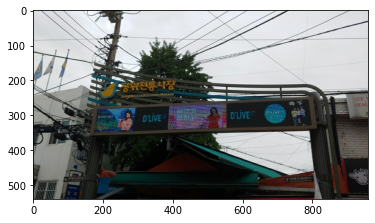

In [30]:
for batch_x, batch_y in dataset:
    print(batch_x.shape, batch_y.shape)

    target_class = np.argmax(batch_y[0].numpy())
    print(category_dict[target_class])
    plt.figure()
    plt.imshow(batch_x[0].numpy())
    # plt.title('{}'.format(category_dict[target_class]))
    plt.show()

    break

In [31]:
target_class = np.argmax(batch_y.numpy(), axis=1)
target_class

array([  65,  805,    3,  695,  430,  992,  728,   50,  659,  845,   66,
        899, 1028,  674, 1018,   78,  572, 1028,  564, 1036,  760,  662,
        900,  580,  446,  732,  219,  594, 1010,  213,  540,  585,   70,
        989,  262,  598,  686,  564,  199,  117,  581,  438,  605,   56,
        992,  934,  981,  315,  435,  667, 1036,  949,   38,  613,  392,
         50,  374,  339,  528,  701,  179,  567,  555,   64])

### TFRecords vs Normal benchmark 

동일한 조건에서 순수한 파일 I/O 속도만을 비교하기 위해서 cache, prepetch, multiprocess와 같은 속도에 영향을 줄 수 있는 요소는 제외하고 측정하였습니다.

- TFRecords 사용 시

In [32]:
get_file(pth.join(data_base_path, 'all_train.tfrecords'))
get_file(pth.join(data_base_path, 'all_val.tfrecords'))
get_file(pth.join(data_base_path, 'test.tfrecords'))

NameError: name 'get_file' is not defined

In [ ]:
dataset = tf.data.TFRecordDataset(train_tfrecord_path, compression_type='GZIP')
dataset = dataset.map(_parse_image_function)

In [ ]:
for _ in tqdm(dataset, position=0, leave=True):
    pass

70481it [05:43, 205.02it/s]


- 일반적인 jpg파일 사용 시

In [ ]:
train_ids, val_ids, train_landmark_ids, val_landmark_ids = train_test_split(train_df['id'], train_df['landmark_id'], test_size=0.2, random_state=7777, shuffle=True)

In [ ]:
def load_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.dtypes.cast(img, tf.float32)
    return img, label

In [ ]:
train_tfrecord_array = np.array([pth.join(data_base_path, 'train', img_name+'.JPG') for img_name in train_ids.values])

dataset = tf.data.Dataset.from_tensor_slices((train_tfrecord_array, train_landmark_ids))
dataset = dataset.map(load_image)

In [ ]:
for _ in tqdm(dataset, position=0, leave=True):
    pass

100%|██████████| 70481/70481 [14:40<00:00, 80.08it/s]


- 결과를 보았을 때, 5분 43초(TFRecords) vs 14분 40초(Normal)로 TFRecord를 사용하는 것이 3배 정도 더 빨랐습니다.  
- jpg 이미지가 속도가 더 오래 걸리는 이유는, jpg 방식으로 압축되어 있는 이미지를 raw 이미지로 해독하는데 걸리는 시간으로 인한 오버헤드로 추정됩니다.
- 저 같은 경우 MobileNetV2 기반 모델이고, 코랩 T4 VGA 기준 학습 속도가 한 에폭에 8~9분정도 걸리는 상황이는 파일 I/O 속도가 전체 학습 속도에 미치는 영향은 상당히 큰 것으로 생각됩니다.   
- 또한 실제 사용에서는 Multiprocessing이나 prefetch와 같은 기능도 같이 사용하기 떄문에 이를 사용해서도 테스트 해보겠습니다.

- TFRecords 사용 시

In [ ]:
dataset = tf.data.TFRecordDataset(train_tfrecord_path, compression_type='GZIP')
dataset = dataset.map(_parse_image_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

for _ in tqdm(dataset, position=0, leave=True):
    pass

70481it [05:43, 205.04it/s]


- 일반적인 jpg로 로딩 시

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((train_tfrecord_array, train_landmark_ids))
dataset = dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

for _ in tqdm(dataset, position=0, leave=True):
    pass

100%|██████████| 70481/70481 [05:46<00:00, 203.17it/s]


- 결과를 보았을 때, 놀랍게도 TFRecord를 사용하는 것과 일반 이미지 로딩 방식이 거의 동일한 시간을 보이는 것을 확인할 수 있습니다.  
- 코랩에서는 앞서 언급한 이미지 압축 해제에 대한 오버헤드를 tf.data의 부가기능을 활용하여 충분히 극복할 수 있는 것으로 보입니다.
- 또한, TRRecord는 그냥 읽는 것과 동일한 시간이 걸리는 것으로 확인되는데, 이는 TFRecord로 읽는 방식 자체가 파일 I/O 이외에 별다른 오버헤드가 크게 없어서 그런 것으로 추정됩니다.